# CNN Modelling

This project is for creating a CNN classifier for gesture recognition

In [3]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [4]:
dataset = pd.read_pickle('dataset.pkl')

In [5]:
def reshape_windows_tensor_with_labels(data, y):
    """
    Converts data from:
        recordings x windows x channels x samples
    to:
        total_windows x channels x samples
    """
    X_windows = []
    y_windows = []
    data = data.to_list()
    y = y.to_list()
    for rec_idx, rec in enumerate(data):
        rec = np.asarray(rec)
        if rec.shape[0] == 0:
            continue

        for window in rec:
            X_windows.append(window)
            y_windows.append(y[rec_idx])

    return np.asarray(X_windows), np.asarray(y_windows)

(1038,)


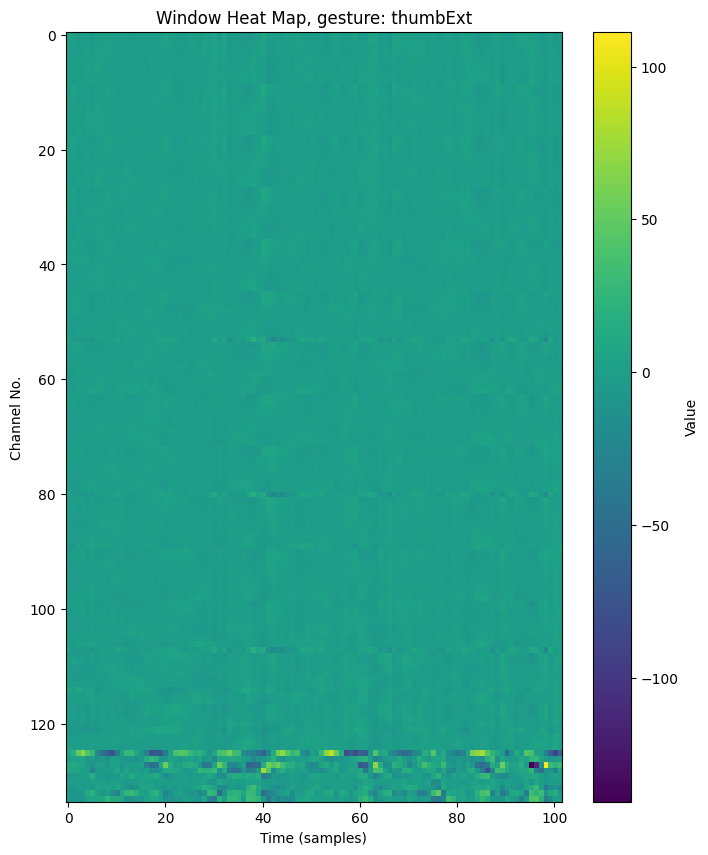

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)

print(X_train.shape)

X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
data = X_train[0]

plt.figure(figsize=(8, 10))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Window Heat Map, gesture: {y_train[0]}')
plt.xlabel('Time (samples)')
plt.ylabel('Channel No.')
plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42707, 134, 102)
(42707,)
(10229, 134, 102)
(10229,)


In [8]:
print("Per-trial containers:")
print("X_train:", type(X_train), getattr(X_train, "shape", None))
print("y_train:", type(y_train), getattr(y_train, "shape", None))

# Convert from per-trial -> per-window (ready for CNN)
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print("\nPer-window tensors (CNN-ready):")
print("X_train shape:", X_train.shape)  # expected: (N_windows, C, T)
print("y_train shape:", y_train.shape)  # expected: (N_windows,)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Quick sanity check of channel/time dims
if X_train.ndim == 3:
    N, C, T = X_train.shape
    print(f"\nCNN expects [N, C, T] -> N={N}, C={C}, T={T}")
else:
    print("\nUnexpected X_train ndim:", X_train.ndim)

Per-trial containers:
X_train: <class 'numpy.ndarray'> (42707, 134, 102)
y_train: <class 'numpy.ndarray'> (42707,)

Per-window tensors (CNN-ready):
X_train shape: (42707, 134, 102)
y_train shape: (42707,)
X_test shape: (10229, 134, 102)
y_test shape: (10229,)

CNN expects [N, C, T] -> N=42707, C=134, T=102


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [10]:
# Split the data: 80% train_temp, 20% test (test set remains fixed)
train_temp_data, X_test, train_temp_labels, y_test = train_test_split(
    dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42
)

# Process test set
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

# Encode labels to integers
le = LabelEncoder()
le.fit(train_temp_labels)  # Fit on all training labels
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print("Classes:", list(le.classes_))

y_test_enc = le.transform(y_test).astype(np.int64, copy=False)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

# Create test DataLoader
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=(device.type == "cuda"))

print(f"Test set size: {len(X_test)}")
print(f"Training pool size: {len(train_temp_data)}")

Number of classes: 9
Classes: ['3digit', 'cilinder', 'fist', 'index_flex', 'middle_flex', 'pinch', 'point', 'thumbExt', 'thumbFlex']
Test set size: 10327
Training pool size: 1038


In [12]:
# DEFINE MODEL AND TRAINING FUNCTIONS

def make_deep_emg_cnn_model(num_classes: int):
    m = nn.Sequential(
        # Block 1
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 5), padding=(1, 2), bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 5), padding=(1, 2), bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.20),

        # Block 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.30),

        # Block 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.40),

        # Global pooling -> avoids hard-coding Linear(in_features=...)
        nn.AdaptiveAvgPool2d((1, 1)),

        # Head
        nn.Flatten(),
        nn.Linear(128, num_classes),
    )
    return m

@torch.no_grad()
def evaluate(model, criterion, loader):
    model.eval()
    ys = []
    ps = []
    total_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += float(loss.item()) * int(yb.size(0))
        n += int(yb.size(0))
        pred = torch.argmax(logits, dim=1)
        ys.append(yb.cpu().numpy())
        ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    return total_loss / max(n, 1), acc, y_true, y_pred

def train_one_epoch(model, criterion, optimizer, scaler, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    n = 0
    
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast('cuda'):
            logits = model(xb)
            loss = criterion(logits, yb)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += float(loss.item()) * int(yb.size(0))
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        n += int(yb.size(0))
    
    train_loss = running_loss / max(n, 1)
    train_acc = correct / max(n, 1)
    return train_loss, train_acc

def train_model(model, criterion, accuracy_fn, optimizer, train_loader, test_loader, num_epochs=30, batch_print=100):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    scaler = torch.GradScaler('cuda')
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, criterion, optimizer, scaler, train_loader)
        val_loss, val_acc, _, _ = evaluate(model, criterion, test_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
    
    return history

def cross_entropy_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [16]:
# Create and train multiple models with different train/val splits
history_array = []
models_array = []
criterion = nn.CrossEntropyLoss()

for run in range(10):
    print(f"\n{'='*60}")
    print(f"Training Run {run + 1}/10")
    print(f"{'='*60}")
    
    # Split training pool 50/50 into train and validation for this run
    X_train, X_val, y_train, y_val = train_test_split(train_temp_data, train_temp_labels, test_size=0.5, shuffle=True)
    
    # Process train and val sets
    X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
    X_val, y_val = reshape_windows_tensor_with_labels(X_val, y_val)
    
    y_train_enc = le.transform(y_train).astype(np.int64, copy=False)
    y_val_enc = le.transform(y_val).astype(np.int64, copy=False)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)
    
    # Create DataLoaders for this run
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=(device.type == "cuda"))
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=(device.type == "cuda"))
    
    # Create fresh model for each run
    model = make_deep_emg_cnn_model(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = train_model(
        model, 
        criterion, 
        cross_entropy_accuracy, 
        optimizer, 
        train_loader, 
        val_loader,
        num_epochs=30, 
        batch_print=100,
    )
    history_array.append(history)
    models_array.append(model)
    
print("\n" + "="*60)
print("All training runs completed!")
print("="*60)


Training Run 1/10
Epoch 1/30 - Train Loss: 1.7386, Train Acc: 0.37, Val Loss: 1.7980, Val Acc: 0.36
Epoch 2/30 - Train Loss: 1.3105, Train Acc: 0.53, Val Loss: 1.8936, Val Acc: 0.40
Epoch 3/30 - Train Loss: 1.0189, Train Acc: 0.65, Val Loss: 1.9050, Val Acc: 0.43
Epoch 4/30 - Train Loss: 0.8326, Train Acc: 0.72, Val Loss: 1.4034, Val Acc: 0.56
Epoch 5/30 - Train Loss: 0.6978, Train Acc: 0.77, Val Loss: 1.4024, Val Acc: 0.58
Epoch 6/30 - Train Loss: 0.5841, Train Acc: 0.81, Val Loss: 1.1206, Val Acc: 0.65
Epoch 7/30 - Train Loss: 0.5102, Train Acc: 0.83, Val Loss: 1.3307, Val Acc: 0.61
Epoch 8/30 - Train Loss: 0.4452, Train Acc: 0.85, Val Loss: 1.3847, Val Acc: 0.62
Epoch 9/30 - Train Loss: 0.3969, Train Acc: 0.87, Val Loss: 1.1887, Val Acc: 0.65
Epoch 10/30 - Train Loss: 0.3482, Train Acc: 0.89, Val Loss: 1.1963, Val Acc: 0.66
Epoch 11/30 - Train Loss: 0.3223, Train Acc: 0.89, Val Loss: 1.1455, Val Acc: 0.68
Epoch 12/30 - Train Loss: 0.2853, Train Acc: 0.91, Val Loss: 1.1670, Val Acc:

In [17]:
# SAVE THE HISTORY ARRAY TO A PICKLE
with open('cnn_training_history.pkl', 'wb') as f:
    pickle.dump(history_array, f)

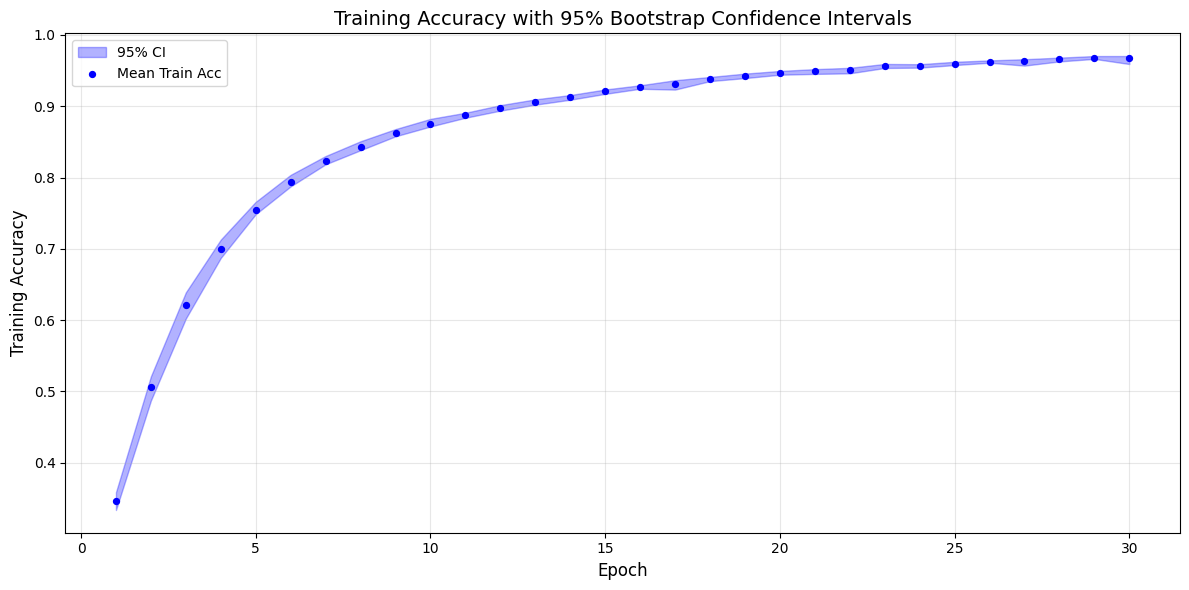

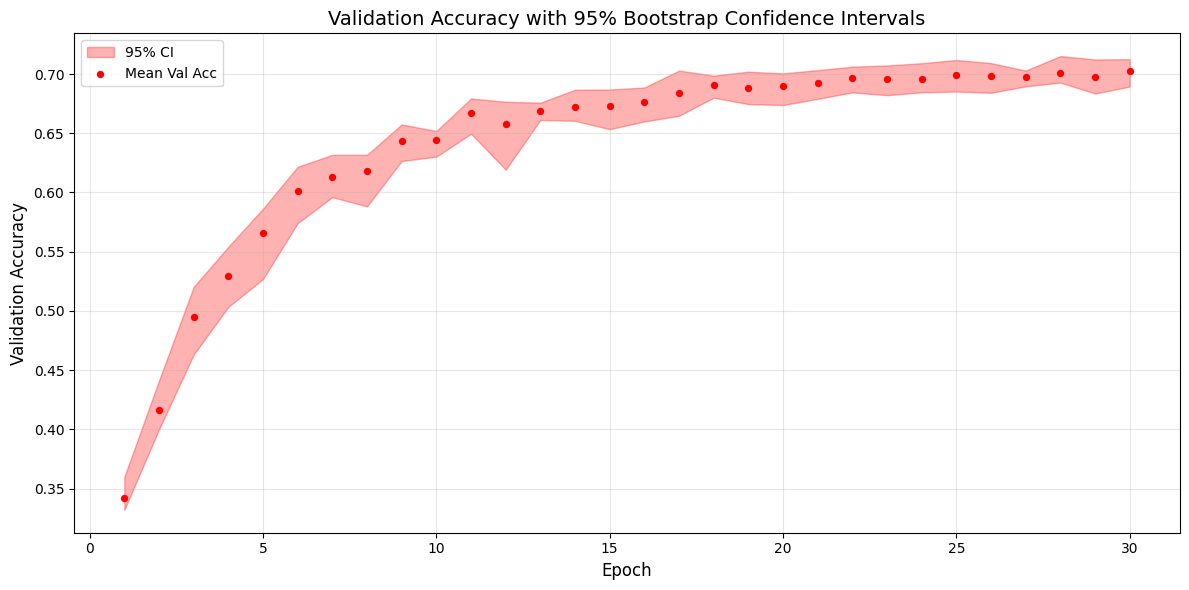


Summary (across runs):
Runs: 10
Epochs: 30
------------------------------------------------------------
Final Epoch Training Acc:   0.9673 [0.9592, 0.9704]
Final Epoch Validation Acc: 0.7030 [0.6894, 0.7126]



In [33]:
# Training + validation accuracy confidence intervals (no model selection, no evaluation)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp_stats

# history_array: list of dicts, each dict has keys: 'train_acc' and 'val_acc'
num_runs = len(history_array)
num_epochs = len(history_array[0]["train_acc"])

train_acc_mean, train_acc_ci_low, train_acc_ci_high = [], [], []
val_acc_mean, val_acc_ci_low, val_acc_ci_high = [], [], []

for epoch in range(num_epochs):
    train_values = np.array([hist["train_acc"][epoch] for hist in history_array], dtype=float)
    val_values = np.array([hist["val_acc"][epoch] for hist in history_array], dtype=float)

    train_ci_low, train_ci_high = sp_stats.bootstrap([train_values], np.mean, confidence_level=0.99).confidence_interval
    val_ci_low, val_ci_high = sp_stats.bootstrap([val_values], np.mean, confidence_level=0.99).confidence_interval

    train_acc_mean.append(float(train_values.mean()))
    train_acc_ci_low.append(float(train_ci_low))
    train_acc_ci_high.append(float(train_ci_high))

    val_acc_mean.append(float(val_values.mean()))
    val_acc_ci_low.append(float(val_ci_low))
    val_acc_ci_high.append(float(val_ci_high))

epochs = np.arange(1, num_epochs + 1)

# Plot training accuracy (means as dots ONLY, no connecting line)
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(epochs, train_acc_ci_low, train_acc_ci_high, alpha=0.3, color="blue", label="95% CI")
ax.scatter(epochs, train_acc_mean, c="blue", s=18, zorder=3, label="Mean Train Acc")  # dots only
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Training Accuracy", fontsize=12)
ax.set_title("Training Accuracy with 95% Bootstrap Confidence Intervals", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot validation accuracy (means as dots ONLY, no connecting line)
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(epochs, val_acc_ci_low, val_acc_ci_high, alpha=0.3, color="red", label="95% CI")
ax.scatter(epochs, val_acc_mean, c="red", s=18, zorder=3, label="Mean Val Acc")  # dots only
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Validation Accuracy", fontsize=12)
ax.set_title("Validation Accuracy with 95% Bootstrap Confidence Intervals", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary (just the CI results; no model evaluation)
print(f"\n{'='*60}")
print("Summary (across runs):")
print(f"{'='*60}")
print(f"Runs: {num_runs}")
print(f"Epochs: {num_epochs}")
print(f"{'-'*60}")
print(f"Final Epoch Training Acc:   {train_acc_mean[-1]:.4f} [{train_acc_ci_low[-1]:.4f}, {train_acc_ci_high[-1]:.4f}]")
print(f"Final Epoch Validation Acc: {val_acc_mean[-1]:.4f} [{val_acc_ci_low[-1]:.4f}, {val_acc_ci_high[-1]:.4f}]")
print(f"{'='*60}\n")

This is not changing after 20 epochs. We will train a new model with the full training data and validate it from our testing

In [35]:
# Create fresh model for each run
X_train, y_train = reshape_windows_tensor_with_labels(train_temp_data, train_temp_labels)

X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N,1,C,T)
y_train_t = torch.tensor(le.transform(y_train).astype(np.int64, copy=False), dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

model = make_deep_emg_cnn_model(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model(
    model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_loader, 
    test_loader,
    num_epochs=20, 
    batch_print=100,
)

Epoch 1/20 - Train Loss: 1.6366, Train Acc: 0.39, Val Loss: 3.1603, Val Acc: 0.38
Epoch 2/20 - Train Loss: 1.1180, Train Acc: 0.60, Val Loss: 1.3536, Val Acc: 0.53
Epoch 3/20 - Train Loss: 0.8733, Train Acc: 0.70, Val Loss: 5.1649, Val Acc: 0.46
Epoch 4/20 - Train Loss: 0.7293, Train Acc: 0.75, Val Loss: 1.2769, Val Acc: 0.62
Epoch 5/20 - Train Loss: 0.6511, Train Acc: 0.78, Val Loss: 1.3043, Val Acc: 0.61
Epoch 6/20 - Train Loss: 0.5868, Train Acc: 0.80, Val Loss: 0.7901, Val Acc: 0.74
Epoch 7/20 - Train Loss: 0.5250, Train Acc: 0.82, Val Loss: 0.8608, Val Acc: 0.73
Epoch 8/20 - Train Loss: 0.4738, Train Acc: 0.84, Val Loss: 0.8170, Val Acc: 0.75
Epoch 9/20 - Train Loss: 0.4410, Train Acc: 0.85, Val Loss: 0.7396, Val Acc: 0.75
Epoch 10/20 - Train Loss: 0.3932, Train Acc: 0.86, Val Loss: 0.7092, Val Acc: 0.77
Epoch 11/20 - Train Loss: 0.3375, Train Acc: 0.88, Val Loss: 0.7763, Val Acc: 0.75
Epoch 12/20 - Train Loss: 0.3239, Train Acc: 0.89, Val Loss: 0.8299, Val Acc: 0.75
Epoch 13/20 -

The final accuracy was 78% after 20 epochs

# **CNN TESTING**

In [13]:
# ===== Block 1: replace your model factory with a parameterized version =====
import torch
import torch.nn as nn

def make_deep_emg_cnn_model(
    num_classes: int,
    num_blocks: int = 3,
    layers_per_block: int = 2,   # option 1: 2 layers, option 2: 3 layers
    base_channels: int = 32,
    dropout_rates=None,          # optional list like [0.2, 0.3, 0.4, 0.4]
):
    assert num_blocks in (2, 3, 4), "num_blocks must be 2, 3, or 4"
    assert layers_per_block in (2, 3), "layers_per_block must be 2 or 3"

    if dropout_rates is None:
        default = [0.20, 0.30, 0.40, 0.40, 0.50, 0.60, 0.70]
        dropout_rates = default[:num_blocks]
    else:
        assert len(dropout_rates) >= num_blocks

    layers = []
    in_ch = 1

    for block_idx in range(num_blocks):
        out_ch = base_channels * (2 ** block_idx)

        k = (3, 5) if block_idx == 0 else (3, 3)
        pad = (1, 2) if k == (3, 5) else (1, 1)

        for layer_idx in range(layers_per_block):
            conv_in = in_ch if layer_idx == 0 else out_ch
            layers.append(nn.Conv2d(conv_in, out_ch, kernel_size=k, padding=pad, bias=False))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(out_ch))

        layers.append(nn.MaxPool2d(kernel_size=(2, 2)))
        layers.append(nn.Dropout(float(dropout_rates[block_idx])))

        in_ch = out_ch

    layers.extend([
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(in_ch, num_classes),
    ])

    return nn.Sequential(*layers)

In [15]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Build the fixed training loader
X_train, y_train = reshape_windows_tensor_with_labels(train_temp_data, train_temp_labels)
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N,1,C,T)
y_train_t = torch.tensor(le.transform(y_train).astype(np.int64, copy=False), dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

configs = []
histories = []
final_val_acc = []

num_blocks_list = [2, 3, 4]
layers_per_block_list = [2, 3]  # "2 options per block"

criterion = nn.CrossEntropyLoss()

for nb in num_blocks_list:
    for lpb in layers_per_block_list:
        cfg = {
            "num_blocks": nb,
            "layers_per_block": lpb,
            "base_channels": 32,
            "lr": 1e-3,
            "epochs": 20,
            "batch_size": 256,
        }
        configs.append(cfg)

        print("\n" + "=" * 70)
        print(f"Training CNN: num_blocks={nb}, layers_per_block={lpb} (20 epochs)")
        print("=" * 70)

        model = make_deep_emg_cnn_model(
            num_classes=num_classes,
            num_blocks=nb,
            layers_per_block=lpb,
            base_channels=32,
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=cfg["lr"])

        history = train_model(
            model,
            criterion,
            cross_entropy_accuracy,
            optimizer,
            train_loader,
            test_loader,
            num_epochs=cfg["epochs"],
            batch_print=100,
        )

        histories.append(history)
        final_acc = float(history["val_acc"][-1]) if "val_acc" in history and len(history["val_acc"]) else float("nan")
        final_val_acc.append(final_acc)

        print(f"Final val acc: {final_acc:.4f}")

best_idx = int(np.nanargmax(final_val_acc))
print("\nBest config:")
print(configs[best_idx])
print(f"Best final val acc: {final_val_acc[best_idx]:.4f}")


Training CNN: num_blocks=2, layers_per_block=2 (20 epochs)
Epoch 1/20 - Train Loss: 1.8169, Train Acc: 0.33, Val Loss: 1.9261, Val Acc: 0.32
Epoch 2/20 - Train Loss: 1.5187, Train Acc: 0.45, Val Loss: 2.0404, Val Acc: 0.33
Epoch 3/20 - Train Loss: 1.2488, Train Acc: 0.56, Val Loss: 1.4900, Val Acc: 0.47
Epoch 4/20 - Train Loss: 1.1122, Train Acc: 0.61, Val Loss: 1.2660, Val Acc: 0.55
Epoch 5/20 - Train Loss: 0.9732, Train Acc: 0.66, Val Loss: 2.0613, Val Acc: 0.46
Epoch 6/20 - Train Loss: 0.9433, Train Acc: 0.68, Val Loss: 1.1377, Val Acc: 0.63
Epoch 7/20 - Train Loss: 0.8654, Train Acc: 0.70, Val Loss: 0.9767, Val Acc: 0.65
Epoch 8/20 - Train Loss: 0.7863, Train Acc: 0.73, Val Loss: 1.0984, Val Acc: 0.63
Epoch 9/20 - Train Loss: 0.7498, Train Acc: 0.75, Val Loss: 0.9769, Val Acc: 0.66
Epoch 10/20 - Train Loss: 0.6897, Train Acc: 0.77, Val Loss: 1.4730, Val Acc: 0.54
Epoch 11/20 - Train Loss: 0.7076, Train Acc: 0.76, Val Loss: 0.8602, Val Acc: 0.71
Epoch 12/20 - Train Loss: 0.6041, Tr

In [16]:
import pickle
import time

sweep_out = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "configs": configs,
    "histories": histories,
    "final_val_acc": final_val_acc,
}

with open("cnn_arch_sweep_blocks_layers.pkl", "wb") as f:
    pickle.dump(sweep_out, f)

print("Saved -> cnn_arch_sweep_blocks_layers.pkl")

Saved -> cnn_arch_sweep_blocks_layers.pkl


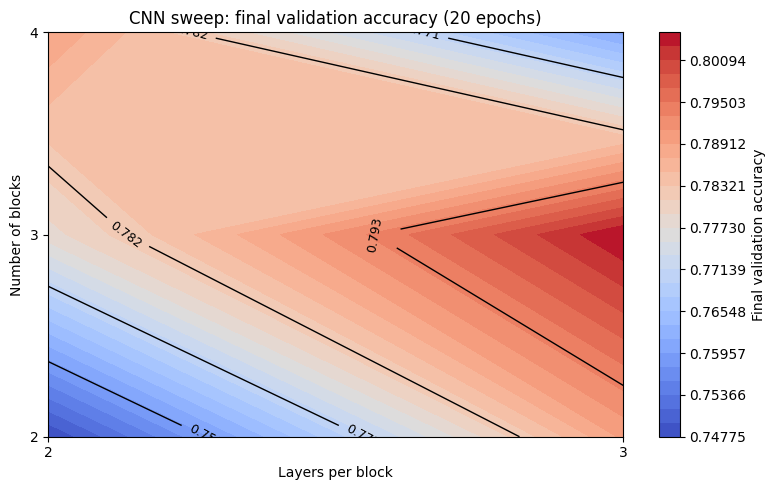

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load sweep results (or use configs/final_val_acc already in memory)
try:
    configs
    final_val_acc
except NameError:
    with open("cnn_arch_sweep_blocks_layers.pkl", "rb") as f:
        sweep_out = pickle.load(f)
    configs = sweep_out["configs"]
    final_val_acc = sweep_out["final_val_acc"]

# Unique axis values
num_blocks_vals = sorted({c["num_blocks"] for c in configs})          # e.g., [2, 3, 4]
layers_vals = sorted({c["layers_per_block"] for c in configs})        # e.g., [2, 3]

# Grid of final accuracies: rows=blocks, cols=layers_per_block
acc_grid = np.full((len(num_blocks_vals), len(layers_vals)), np.nan, dtype=float)
for cfg, acc in zip(configs, final_val_acc):
    r = num_blocks_vals.index(cfg["num_blocks"])
    c = layers_vals.index(cfg["layers_per_block"])
    acc_grid[r, c] = float(acc)

# Meshgrid for contour plots (X=layers per block, Y=num blocks)
X, Y = np.meshgrid(layers_vals, num_blocks_vals)  # both shape == acc_grid.shape

vmin = float(np.nanmin(acc_grid))
vmax = float(np.nanmax(acc_grid))

# Contour levels (adjust count if you want more/less bands)
filled_levels = np.linspace(vmin, vmax, 30)
line_levels = np.linspace(vmin, vmax, 6)

plt.figure(figsize=(8, 5))

# Filled contours + contour lines + labels (SVM-style)
cf = plt.contourf(X, Y, acc_grid, levels=filled_levels, cmap="coolwarm", vmin=vmin, vmax=vmax)
plt.colorbar(cf, label="Final validation accuracy")

cs = plt.contour(X, Y, acc_grid, levels=line_levels, colors="k", linewidths=1.0)
plt.clabel(cs, cs.levels, inline=True, fontsize=9, fmt="%.3f")

plt.title("CNN sweep: final validation accuracy (20 epochs)")
plt.xlabel("Layers per block")
plt.ylabel("Number of blocks")

plt.xticks(layers_vals, [str(v) for v in layers_vals])
plt.yticks(num_blocks_vals, [str(v) for v in num_blocks_vals])

plt.tight_layout()
plt.show()

In [24]:
# Best architecture from sweep: 3 blocks, 3 layers per block
BEST_NUM_BLOCKS = 3
BEST_LAYERS_PER_BLOCK = 3
BEST_BASE_CHANNELS = 32

# (optional) keep dropout consistent across runs
BEST_DROPOUT_RATES = [0.20, 0.30, 0.40]  # length must be >= BEST_NUM_BLOCKS

# This assumes you already defined the parameterized `make_deep_emg_cnn_model(...)`
# and that `num_classes` + `device` already exist in your notebook.
model = make_deep_emg_cnn_model(
    num_classes=num_classes,
    num_blocks=BEST_NUM_BLOCKS,
    layers_per_block=BEST_LAYERS_PER_BLOCK,
    base_channels=BEST_BASE_CHANNELS,
    dropout_rates=BEST_DROPOUT_RATES,
).to(device)

print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2), bias=False)
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2), bias=False)
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(32, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2), bias=False)
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Dropout(p=0.2, inplace=False)
  (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (12): ReLU()
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (15): ReLU()
  (16): Bat

In [25]:
# Create fresh model for each run
X_train, y_train = reshape_windows_tensor_with_labels(train_temp_data, train_temp_labels)

X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N,1,C,T)
y_train_t = torch.tensor(le.transform(y_train).astype(np.int64, copy=False), dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

model = make_deep_emg_cnn_model(
    num_classes=num_classes,
    num_blocks=BEST_NUM_BLOCKS,
    layers_per_block=BEST_LAYERS_PER_BLOCK,
    base_channels=BEST_BASE_CHANNELS,
    dropout_rates=BEST_DROPOUT_RATES,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model(
    model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_loader, 
    test_loader,
    num_epochs=20, 
    batch_print=100,
)

Epoch 1/20 - Train Loss: 1.6347, Train Acc: 0.40, Val Loss: 1.6033, Val Acc: 0.44
Epoch 2/20 - Train Loss: 1.1174, Train Acc: 0.60, Val Loss: 1.7942, Val Acc: 0.44
Epoch 3/20 - Train Loss: 0.8513, Train Acc: 0.70, Val Loss: 1.0889, Val Acc: 0.62
Epoch 4/20 - Train Loss: 0.6728, Train Acc: 0.77, Val Loss: 2.7251, Val Acc: 0.49
Epoch 5/20 - Train Loss: 0.6642, Train Acc: 0.77, Val Loss: 1.2694, Val Acc: 0.61
Epoch 6/20 - Train Loss: 0.5262, Train Acc: 0.82, Val Loss: 1.0303, Val Acc: 0.69
Epoch 7/20 - Train Loss: 0.5453, Train Acc: 0.81, Val Loss: 0.7158, Val Acc: 0.76
Epoch 8/20 - Train Loss: 0.4317, Train Acc: 0.85, Val Loss: 0.8548, Val Acc: 0.74
Epoch 9/20 - Train Loss: 0.4264, Train Acc: 0.85, Val Loss: 0.9067, Val Acc: 0.72
Epoch 10/20 - Train Loss: 0.4565, Train Acc: 0.84, Val Loss: 0.6881, Val Acc: 0.77
Epoch 11/20 - Train Loss: 0.3033, Train Acc: 0.90, Val Loss: 0.8720, Val Acc: 0.74
Epoch 12/20 - Train Loss: 0.3792, Train Acc: 0.87, Val Loss: 0.6803, Val Acc: 0.78
Epoch 13/20 -

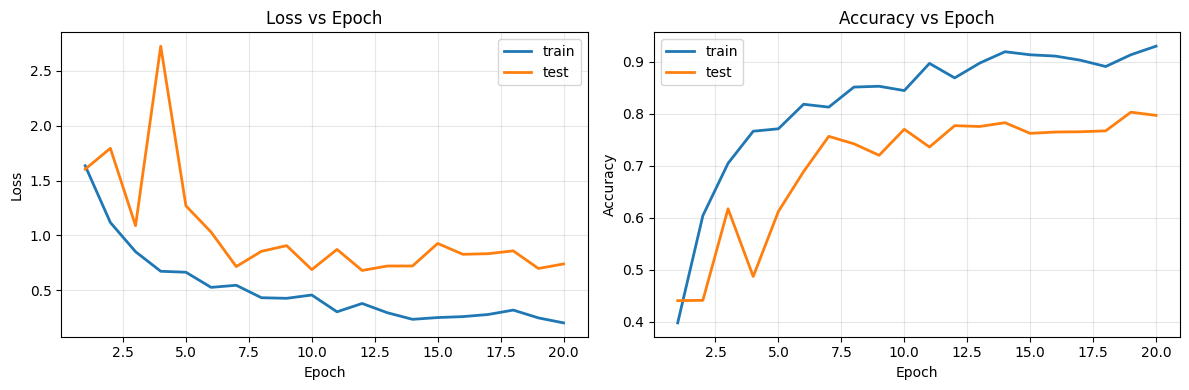

Test loss: 0.7396
Test accuracy: 0.7966

Classification report:
              precision    recall  f1-score   support

      3digit     0.6104    0.8514    0.7111       646
    cilinder     0.8970    0.8783    0.8876      2211
        fist     0.7842    0.7140    0.7474       860
  index_flex     0.7938    0.6669    0.7248      1663
 middle_flex     0.8014    0.7071    0.7513      1335
       pinch     0.7304    0.8789    0.7978       900
       point     0.7927    0.8553    0.8228       836
    thumbExt     0.9714    0.7899    0.8713       947
   thumbFlex     0.7091    0.8762    0.7838       929

    accuracy                         0.7966     10327
   macro avg     0.7878    0.8020    0.7886     10327
weighted avg     0.8077    0.7966    0.7971     10327



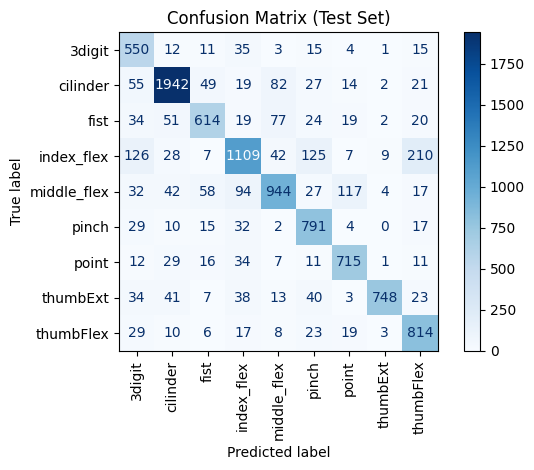

In [26]:
# ---- Plot training curves + classification report + confusion matrix (test set) ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

# 1) Plot training history (loss + accuracy)
epochs = np.arange(1, len(history["train_loss"]) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(epochs, history["train_loss"], label="train", linewidth=2)
if "val_loss" in history and len(history["val_loss"]) == len(epochs):
    axes[0].plot(epochs, history["val_loss"], label="test", linewidth=2)
axes[0].set_title("Loss vs Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Accuracy
axes[1].plot(epochs, history["train_acc"], label="train", linewidth=2)
if "val_acc" in history and len(history["val_acc"]) == len(epochs):
    axes[1].plot(epochs, history["val_acc"], label="test", linewidth=2)
axes[1].set_title("Accuracy vs Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# 2) Evaluate on test set using your existing function
test_loss, test_acc, y_true, y_pred = evaluate(model, criterion, test_loader)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# 3) Classification report + confusion matrix
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

disp = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=le.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()